registration with template

In [ ]:
import os

os.environ['PATH'] += ':/opt/ANTs/bin' # ensure the ANTs binaries are in $PATH
os.environ['ANTSPATH'] = '/opt/ANTs/bin/'

In [ ]:
import os
import glob
import numpy as np
import pandas as pd

images_dir = '/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_images/'
output_dir = '/home/jaimebarranco/Desktop/eye_model/combined/output/registrationToTemplate/'
template = '/home/jaimebarranco/Desktop/eye_model/combined/output/templateConstruction/template0.nii.gz'

for file in sorted(glob.glob(images_dir + '*_cropped.nii.gz')):
        filename = os.path.basename(file)
        output_folder = output_dir + filename.split("_")[0] + '/'
        # print(output_folder)

        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        ## antsRegistrationSyNQuick # s: rigid + affine + deformable syn (3 stages)
        command1 = 'antsRegistrationSyNQuick.sh -d 3' + \
        ' -m ' + file                                 + \
        ' -f ' + template                             + \
        ' -t ' + 's'                                  + \
        ' -o ' + output_folder                        + \
        ' -n ' + '16'
        # print(command1)
        os.system(command1)


copy atlas' labels to input folder

In [ ]:
import shutil

input_atlas_labels_dir = "/mnt/sda1/Repos/a-eye/Data/SHIP_dataset/non_labeled_dataset/non_labeled_dataset_nifti_reg_2/"
output_atlas_labels_dir = "/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/atlas/"

for file in sorted(glob.glob(input_atlas_labels_dir + '*/labels.nii.gz', recursive=True)):
    filename = os.path.basename(file)
    # print(file.split("/")[-2])
    shutil.copy(file, os.path.join(output_atlas_labels_dir, f'{file.split("/")[-2]}.nii.gz'))

copy nnunet labels to input folder

In [ ]:
import shutil

input_nnunet_labels_dir = "/mnt/sda1/Repos/a-eye/a-eye_segmentation/deep_learning/nnUNet/nnUNet/nnUNet_inference/no_postprocessing_cropped_alligned/"
output_nnunet_labels_dir = "/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/nnunet/"

for file in sorted(glob.glob(input_nnunet_labels_dir + '*.nii.gz', recursive=True)):
    filename = os.path.basename(file)
    # print(filename.split("_")[0])
    shutil.copy(file, os.path.join(output_nnunet_labels_dir, f'{filename.split("_")[0]}.nii.gz'))

apply transform to labels from subjects to template (direct transform)

In [ ]:
labels_dir = '/home/jaimebarranco/Desktop/eye_model/combined/input/cropped_labels/nnunet/' # atlas or nnunet
output_dir = '/home/jaimebarranco/Desktop/eye_model/combined/output/registrationToTemplate/'
template = '/home/jaimebarranco/Desktop/eye_model/combined/output/templateConstruction/template0.nii.gz'

for file in sorted(glob.glob(labels_dir + '*.nii.gz')):
        filename = os.path.basename(file)
        output_folder = output_dir + filename.split(".")[0] + '/'
        # print(output_folder)
        
        # antsApplyTransforms with inverse transform to get the template labels into subject space
        command2 = 'antsApplyTransforms -d 3 ' + \
        ' -i ' +  file + \
        ' -r ' +  template + \
        ' -t ' + output_folder + '1Warp.nii.gz' + \
        ' -t ' + output_folder + '0GenericAffine.mat' + \
        ' -n ' + 'MultiLabel' + \
        ' -o ' +  output_folder + 'labels_nnunet.nii.gz' + \
        ' --float 0 --verbose 1'
        # print(command2)
        os.system(command2)

        # Dealing with files in that folder
        # for f in glob.glob(output_image_path + 'labels.nii.gz'):
        #     os.remove(f)

probability per voxel to belong to a certain structure of the eye
---

array generation

In [ ]:
import nibabel as nb
import numpy as np
import glob, os

labels_dir = '/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/registrationToTemplate/'
num_images = len(os.listdir(labels_dir))

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + '*/labels_nnunet.nii.gz'))[0] # atlas or nnunet
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape  # (77, 95, 94)
print(image_shape)

In [ ]:
# (1210, 77, 95, 94) array generation
labels_matrix = np.empty((num_images, *image_shape))  # (1210, 77, 95, 94)
for idx, file in enumerate(sorted(glob.glob(labels_dir + '*/labels_nnunet.nii.gz'))):  # atlas or nnunet
    sub = file.split("/")[-2] # str
    # print(idx)
    # print(file)
    # print(sub)
    labels = nb.load(file)
    # labels_shape = labels.shape
    # print(labels_shape)
    labels_data = labels.get_fdata()
    labels_matrix[idx] = labels_data

voxel_arrays = np.moveaxis(labels_matrix, 0, -1)
print(voxel_arrays.shape)  # (77, 95, 94, 1210)

In [ ]:
# Save voxel_arrays to a .npy file
np.save('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/voxel_arrays.npy', voxel_arrays)

In [ ]:
# Load voxel_arrays
voxel_arrays = np.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/voxel_arrays.npy')

max prob map

In [ ]:
from collections import Counter

# matrices for most likely tissue (median) and probability of that tissue (divided by number of images)
stat_matrix = np.empty(image_shape) # statistic matrix
prob_matrix = np.empty(image_shape)

# mode extended and probability calculation for each voxel
for x in range(image_shape[0]):
    for y in range(image_shape[1]):
        for z in range(image_shape[2]):
            voxel_values = voxel_arrays[x, y, z, :]
            freq = Counter(voxel_values)
            voxel_frequencies = freq.most_common() # [(label, frequency), ...]
            # [0][0] most frequent value, [1][0] second most frequent value
            # [0][1] most frequent frequency, [1][1] second most frequent frequency
            voxel_value = voxel_frequencies[0][0]
            voxel_value_frequency = voxel_frequencies[0][1]
            stat_matrix[x, y, z] = voxel_value

In [ ]:
# Save the entire max prob map to a .npy file
np.save('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/max_prob_map.npy', stat_matrix)

# Save max prob map as nifti
stat_nifti = nb.Nifti1Image(stat_matrix, sample_image.affine, sample_image.header)
nb.save(stat_nifti, '/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/max_prob_map.nii.gz')

probs

In [ ]:
# Calculate the probability distribution for each voxel
num_labels = 10
probs = np.zeros((image_shape[0], image_shape[1], image_shape[2], num_labels))
for label in range(num_labels):
    probs[:, :, :, label] = np.mean(voxel_arrays == label, axis=3)

In [ ]:
probs[34, 66, 66, :] # example of probabilities for a voxel

In [ ]:
# Save the prob matrix to a .npy file
np.save('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/probs.npy', probs)

In [ ]:
"""Load probs matrix"""
import numpy as np
probs = np.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/probs.npy')

colors

In [ ]:
# Define names for the different labels (tissues)
label_names = {
    0: 'background',
    1: 'lens',
    2: 'globe',
    3: 'optic nerve',
    4: 'intraconal fat',
    5: 'extraconal fat',
    6: 'lateral rectus muscle',
    7: 'medial rectus muscle',
    8: 'inferior rectus muscle',
    9: 'superior rectus muscle',
}

# define colors for the different labels (tissues)
colors = {
    0: [0, 0, 0], # background - black
    1: [1, 0, 0],  # lens - tab:red
    2: [0, 1, 0],  # globe - green
    3: [0, 0, 1],  # optic nerve - tab:blue
    4: [1, 1, 0],  # intraconal fat - yellow
    5: [0, 1, 1],  # extraconal fat - cyan
    6: [1, 0, 1],  # lateral rectus muscle - magenta
    7: [0, 1, 0.5],  # medial rectus muscle - aquamarine
    8: [1, 0.5, 0],  # inferior rectus muscle - purple
    9: [0.5, 0, 1],  # superior rectus muscle - orange
}

distribution of probs per label

In [ ]:
''' Distribution of probabilities per label '''

import numpy as np
import matplotlib.pyplot as plt

# Number of bins for the histogram
num_bins = 10

# Prepare the bins, starting slightly above 0 to avoid zero probabilities
bins = np.linspace(1e-6, 1, num_bins + 1)

# Plot histogram for each label, excluding label 0
for label in range(len(colors)):
    # Initialize a new plot for each label
    fig, ax = plt.subplots(figsize=(10, 6))

    # Extract probabilities for the current label
    probabilities = probs[..., label].flatten()

    # Filter probabilities greater than 0.1
    probabilities = probabilities[probabilities > 0.1]
    
    # Compute histogram
    counts, bin_edges = np.histogram(probabilities, bins=bins)
    
    # Plot the histogram as bars
    ax.bar(bin_edges[:-1], counts, width=(bin_edges[1] - bin_edges[0]), 
        align='edge', label=f'{label_names[label]}', color=colors[label], alpha=0.7)
    
    # Customize the plot
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of Probabilities for Label {label_names[label]}')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(left=0.1)  # Set the x-axis to start at 0.1
    
    # Save the plot as a PNG file
    # fig.savefig(f'/home/jaimebarranco/Desktop/eye_model/combined/output/maps/nnunet/histogram_per_label/adjusted/{label}_{label_names[label]}_adjusted.png', format='png')
    
    # Show the plot
    plt.show

HSV

In [ ]:
import matplotlib.colors as mcolors
# matplotlib (https://matplotlib.org/stable/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py)

# colors to rgb using matplotlib
rgb_colors = {}
for key, value in colors.items():
    rgb_colors[key] = mcolors.to_rgb(value) # no alpha channel
print("rgb: ", rgb_colors)

# colors to hsv
hsv_colors = {}
for key, value in rgb_colors.items():
    hsv_colors[key] = mcolors.rgb_to_hsv(value)
print("hsv: ", hsv_colors)

# Create the output image
output_image_rgb = np.zeros((image_shape[0], image_shape[1], image_shape[2], 3)) # 3 channels

# Reduce intensity based on probabilities
for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        for k in range(image_shape[2]):
            blended_rgb = np.zeros(3)
            for label in range(len(colors)):
                hsv = hsv_colors[label].copy()
                hsv[1] *= probs[i, j, k, label]  # Reduce intensity (Saturation)
                hsv[2] *= probs[i, j, k, label]  # Reduce intensity (Value)
                blended_rgb += mcolors.hsv_to_rgb(hsv)
            output_image_rgb[i, j, k] = blended_rgb

# Normalize to keep RGB values within [0, 1]
output_image_rgb = np.clip(output_image_rgb, 0, 1)

# Convert back to 0-255 range for visualization
output_image_rgb = (output_image_rgb * 255).astype(np.uint8)

# save the output_rgb_image as a .npy file
np.save('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/prob_map_hsv.npy', output_image_rgb)

# save the output_rgb_image as a nifti file
output_image_nifti = nb.Nifti1Image(output_image_rgb, sample_image.affine, sample_image.header)
nb.save(output_image_nifti, f'/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/prob_map_hsv.nii.gz')

RGB - Yasser

In [ ]:
""" Create ponderated RGB image for all subjects per label"""

import numpy as np
import nibabel as nb
import glob, os

labels_dir = '/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/registrationToTemplate/'
num_images = len(os.listdir(labels_dir))

# sample image to get the shape
sample_image_path = sorted(glob.glob(labels_dir + '*/labels_nnunet.nii.gz'))[0] # atlas or nnunet
sample_image = nb.load(sample_image_path)
image_shape = sample_image.shape  # (77, 95, 94)
print(image_shape)

# define colors for the different labels (tissues)
colors = {
    0: [0, 0, 0], # background - black
    1: [1, 0, 0],  # lens - tab:red
    2: [0, 1, 0],  # globe - green
    3: [0, 0, 1],  # optic nerve - tab:blue
    4: [1, 1, 0],  # intraconal fat - yellow
    5: [0, 1, 1],  # extraconal fat - cyan
    6: [1, 0, 1],  # lateral rectus muscle - magenta
    7: [0, 1, 0.5],  # medial rectus muscle - aquamarine
    8: [1, 0.5, 0],  # inferior rectus muscle - purple
    9: [0.5, 0, 1],  # superior rectus muscle - orange
}

# Define names for the different labels (tissues)
label_names = {
    0: '0_background',
    1: '1_lens',
    2: '2_globe',
    3: '3_optic_nerve',
    4: '4_intraconal_fat',
    5: '5_extraconal_fat',
    6: '6_lateral_rectus_muscle',
    7: '7_medial_rectus_muscle',
    8: '8_inferior_rectus_muscle',
    9: '9_superior_rectus_muscle',
}

# Load voxel_arrays
# matrix = np.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/voxel_arrays.npy')
# matrix_shape = matrix.shape
num_subjects = 1210  # matrix_shape[3]
probs = np.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/probs.npy')

# Initialize the volumes for each channel at the same dimension as the initial volume
dim = np.array([image_shape[0], image_shape[1], image_shape[2]])
Ir = np.zeros(dim)
Ig = np.zeros(dim)
Ib = np.zeros(dim)
Isum = np.zeros(dim)
Im = np.zeros(dim)

# Iterate over the labels
for label_num in range(1, len(colors)):

    label_name = label_names[label_num]
    It = probs[..., label_num]

    # Accumulates the weighted volume into the Ir array, scaled by
    # the color component for the current track
    Ir += It * colors[label_num][0]
    Ig += It * colors[label_num][1]
    Ib += It * colors[label_num][2]

    # Accumulates the unweighted volume into the Isum array
    Isum += It

    # Takes the element-wise maximum between the current Im and It
    Im = np.maximum(Im, It)

# Find indices where Isum is not zero
ind = np.where(Isum != 0)

# Normalize RGB values
Ir[ind] /= Isum[ind]
Ig[ind] /= Isum[ind]
Ib[ind] /= Isum[ind]

# Scale by the maximum intensity
Ir *= Im
Ig *= Im
Ib *= Im

# Create the RGB image with dimensions (77, 95, 94, 3)
output_image_rgb = np.stack([Ir, Ig, Ib], axis=3)

# save the output_rgb_image as a nifti file
output_image_nifti = nb.Nifti1Image(output_image_rgb, sample_image.affine, sample_image.header)
nb.save(output_image_nifti, f'/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/prob_map_rgb.nii.gz')

load rgb image

In [3]:
"""Load rgb_image"""
import nibabel as nb
output_image_rgb_nii = nb.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/prob_map_rgb.nii.gz')
output_image_rgb = output_image_rgb_nii.get_fdata()

In [ ]:
import numpy as np
output_image_rgb = np.load('/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/prob_map_hsv.npy')

save slices as png files

In [ ]:
''' Save all slices as PNG files '''

import os
import matplotlib.pyplot as plt

output_dir = "/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/maps/nnunet/prob_map_nnunet_hsv"  # Directory to save the PNG files
os.makedirs(output_dir, exist_ok=True)

for z in range(40, output_image_rgb.shape[2]):
    slice_rgb = output_image_rgb[:, :, z, :]
    plt.imshow(slice_rgb)
    plt.axis('off')
    plt.savefig(f"{output_dir}/slice_{z}.png", bbox_inches='tight', pad_inches=0)
    plt.close()

visualizer z=67

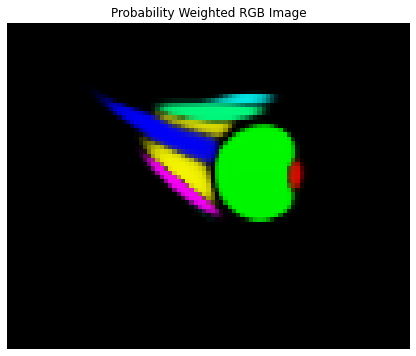

In [4]:
''' Visualize'''

import matplotlib.pyplot as plt

# To visualize a single slice (e.g., the first slice in the third dimension)
plt.figure(figsize=(8, 6))  # replace width and height with desired values
plt.imshow(output_image_rgb[..., 67, :], interpolation='nearest')
plt.title('Probability Weighted RGB Image')
plt.axis('off')
plt.show()

visualizer with Z-axis slider

In [ ]:
''' Visualize with a Z-axis slider'''

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1)

# Function to create a 2D plot for a specific z slice
def plot_2d_slice(rgb_image, z_index):
    plt.figure(figsize=(8, 12))
    plt.imshow(rgb_image[:, :, z_index], interpolation='none')
    plt.title(f'Slice at z = {z_index}')
    plt.axis('off')
    plt.show()

# Interactive function to update the plot based on slider value
def update_plot(z_index):
    plot_2d_slice(rotated_output_image_rgb, z_index)

# Rotate prob_map
rotated_output_image_rgb = rotate_image(output_image_rgb)

# Create the slider widget
z_slider = widgets.IntSlider(min=0, max=rotated_output_image_rgb.shape[2]-1, step=1, value=0, description='Z-axis')

# Use interact to update the plot when the slider value changes
interact(update_plot, z_index=z_slider)

visualizer with overlap with the template image

In [ ]:
''' Visualize with an interactive 3D plot''' # TODO leave fixed the image and overlay the output_image_rgb (with an optional slider for the opacity of the labels)

import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# Load the template image
template_path = '/mnt/sda1/Repos/a-eye/Output/eye_model/combined/output/templateConstruction/template0.nii.gz'
template_img = nb.load(template_path)
template_data = template_img.get_fdata()

# Function to rotate an image 90 degrees to the left
def rotate_image(image):
    return np.rot90(image, k=1)

# Create a function to plot both images overlapped
def plot_images(alpha_prob_map, alpha_overlay, z_index):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Rotate template image
    rotated_template = rotate_image(template_data)

    # Rotate prob_map
    rotated_prob_map = rotate_image(output_image_rgb)

    # Plot the rotated template image
    ax.imshow(rotated_template[:, :, z_index], cmap='gist_gray', interpolation='none', alpha=1)

    # Extract RGB channels from prob_map
    rgb_channels = rotated_prob_map[..., z_index, :]

    # Normalize RGB channels for intensity adjustment
    rgb_channels_norm = rgb_channels / np.max(rgb_channels)

    # Apply intensity adjustment to prob_map
    adjusted_prob_map = rgb_channels_norm * alpha_prob_map

    # Overlay the prob_map with adjustable transparency
    ax.imshow(adjusted_prob_map, alpha=alpha_overlay)

    # Set title and turn off axis
    ax.set_title('Overlayed Image')
    ax.axis('off')

    # Show the plot
    plt.show()

# Create sliders for adjusting alpha of probability map and overlay, and z-axis slice
alpha_prob_map_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=1, description='Alpha Prob Map')
alpha_overlay_slider = widgets.FloatSlider(min=0, max=1, step=0.05, value=0.5, description='Overlay')
z_slider = widgets.IntSlider(min=0, max=template_data.shape[2] - 1, step=1, value=template_data.shape[2] // 2, description='Z-axis')

# Create an interactive plot
interact(plot_images, alpha_prob_map=alpha_prob_map_slider, alpha_overlay=alpha_overlay_slider, z_index=z_slider)
